In [1]:
import rerun as rr
import genjax
import os
import numpy as np
import jax.numpy as jnp
import jax
from b3d import Pose
import b3d
from tqdm import tqdm
import trimesh
import pytest
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib

In [2]:
## L2 distance test

PORT = 8812
rr.init("233")
rr.connect(addr=f"127.0.0.1:{PORT}")

In [3]:
def gaussian_depth_likelihood(observed_depth, rendered_depth, depth_variance):
    return -jnp.power((observed_depth - rendered_depth) / depth_variance, 2)


def gaussian_rgb_likelihood(observed_rgb, rendered_rgb, rgb_variance):
    return -jnp.power(
        (b3d.colors.rgb_to_lab(observed_rgb) - b3d.colors.rgb_to_lab(rendered_rgb))
        / rgb_variance,
        2,
    )


# TODO: L2 loss on color spacee
def gaussian_likelihood(
    observed_rgb,
    rendered_rgb,
    observed_depth,
    rendered_depth,
    depth_variance,
    rgb_variance,
):
    rgb_score = gaussian_rgb_likelihood(observed_rgb, rendered_rgb, rgb_variance).sum(
        axis=2
    )
    depth_score = gaussian_depth_likelihood(
        observed_depth, rendered_depth, depth_variance
    )
    return {
        "score": rgb_score + depth_score,
        "rgb_score": rgb_score,
        "depth_score": depth_score,
    }

In [4]:
likelihood = jax.vmap(gaussian_likelihood, in_axes=(None, 0, None, 0, None, None))

/opt/conda/envs/b3d2/lib/python3.12/site-packages/trimesh/grouping.py:99: RuntimeWarning: invalid value encountered in cast
  stacked = np.column_stack(stacked).round().astype(np.int64)


Vertices dimensions : [0.116984   0.09313101 0.081303  ]


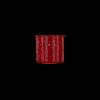

In [5]:
image_width, image_height, fx, fy, cx, cy, near, far = (
    100,
    100,
    200.0,
    200.0,
    50.0,
    50.0,
    0.01,
    10.0,
)
renderer = b3d.Renderer(image_width, image_height, fx, fy, cx, cy, near, far)

mesh_path = os.path.join(
    b3d.get_root_path(), "assets/shared_data_bucket/025_mug/textured.obj"
)
mesh = trimesh.load(mesh_path)
vertices = jnp.array(mesh.vertices)
vertices = vertices - jnp.mean(vertices, axis=0)
faces = jnp.array(mesh.faces)
vertex_colors = vertices * 0.0 + jnp.array([1.0, 0.0, 0.0])
vertex_colors = jnp.array(mesh.visual.to_color().vertex_colors)[..., :3] / 255.0
print("Vertices dimensions :", vertices.max(0) - vertices.min(0))

key = jax.random.PRNGKey(0)

camera_pose = Pose.from_position_and_target(
    jnp.array([0.6, 0.0, 0.0]), jnp.array([0.0, 0.0, 0.0])
)

cp_to_pose = lambda cp: Pose(
    jnp.array([cp[0], cp[1], 0.0]),
    b3d.Rot.from_rotvec(jnp.array([0.0, 0.0, cp[2]])).as_quat(),
)
object_library = b3d.MeshLibrary.make_empty_library()
object_library.add_object(vertices, faces, vertex_colors)

cps_to_test = [
    jnp.array([0.0, 0.0, jnp.pi]),  # Hidden
    jnp.array([0.0, 0.0, -jnp.pi / 2]),  # Side
    jnp.array([0.0, 0.0, 0.0]),  # Front
    jnp.array([0.0, 0.0, +jnp.pi / 2]),  # Side
]

text_index = 0  # 1

gt_cp = cps_to_test[text_index]

object_pose = cp_to_pose(gt_cp)

gt_img, gt_depth = renderer.render_attribute(
    (camera_pose.inv() @ object_pose)[None, ...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges[jnp.array([0])],
    object_library.attributes,
)
b3d.get_rgb_pil_image(gt_img)

In [6]:
# delta_cps = jnp.stack(
#     jnp.meshgrid(
#         jnp.linspace(-0.02, 0.02, 31),
#         jnp.linspace(-0.02, 0.02, 31),
#         jnp.linspace(-jnp.pi, jnp.pi, 71),
#     ),
#     axis=-1,
# ).reshape(-1, 3)

delta_cps = jnp.stack(
    jnp.meshgrid(
        jnp.linspace(-0.1, 0.1, 30),
        jnp.linspace(-0.1, 0.1, 30),
        jnp.linspace(-jnp.pi, jnp.pi, 71),
    ),
    axis=-1,
).reshape(-1, 3)

cp_delta_poses = jax.vmap(cp_to_pose)(delta_cps)

test_poses = object_pose @ cp_delta_poses

test_poses_batches = test_poses.split(100)

In [7]:
scores = []
rgb_scores = []
depth_scores = []
depth_variance, rgb_variance = 1.0, 120.0  # 0.5, 60

for batch in test_poses_batches:
    rgb_ims, depth_ims = renderer.render_attribute_many(
        (camera_pose.inv() @ batch)[:, None, ...],
        object_library.vertices,
        object_library.faces,
        object_library.ranges[jnp.array([0])],
        object_library.attributes,
    )
    scores_batch = likelihood(
        gt_img, rgb_ims, gt_depth, depth_ims, depth_variance, rgb_variance
    )["score"]
    scores.append(scores_batch.sum(axis=(1, 2)))
    # inlier_scores.append(scores_dict['inlier_score'])


scores = jnp.concatenate(scores)
samples = jax.random.categorical(key, scores, shape=(50,))

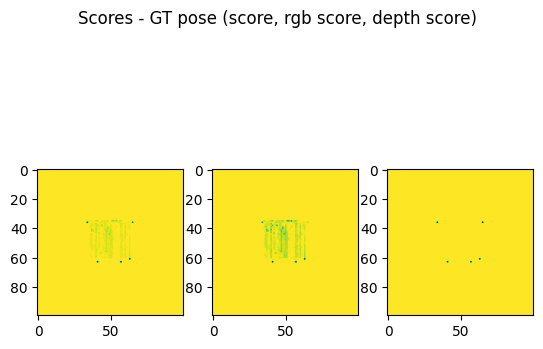

In [8]:
original_view_im, original_view_depth = renderer.render_attribute(
    (camera_pose.inv() @ test_poses[jnp.argsort(scores)[::-1][2]])[None, ...],  #
    object_library.vertices,
    object_library.faces,
    object_library.ranges[jnp.array([0])],
    object_library.attributes,
)

# generate inlier/outlier maps


pixel_scores = gaussian_likelihood(
    gt_img,
    original_view_im,
    gt_depth,
    original_view_depth,
    depth_variance,
    rgb_variance,
)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle("Scores - GT pose (score, rgb score, depth score)")
ax1.imshow(pixel_scores["score"])
ax2.imshow(pixel_scores["rgb_score"])
ax3.imshow(pixel_scores["depth_score"])

In [9]:
samples = jax.random.categorical(key, scores, shape=(50,))
print("GT Contact Parameter :", gt_cp)

samples_deg_range = jnp.rad2deg(
    (jnp.max(delta_cps[samples], axis=0) - jnp.min(delta_cps[samples], axis=0))[2]
)

print("Sampled Angle Range:", samples_deg_range)
pix_scores = scores

GT Contact Parameter : [0.        0.        3.1415927]
Sampled Angle Range: 144.0


In [10]:
alternate_camera_pose = Pose.from_position_and_target(
    jnp.array([0.01, 0.000, 0.9]), object_pose.pos
)
alternate_view_images, _ = renderer.render_attribute_many(
    (alternate_camera_pose.inv() @ test_poses[samples])[:, None, ...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges[jnp.array([0])],
    object_library.attributes,
)

original_view_images, original_view_depths = renderer.render_attribute_many(
    (camera_pose.inv() @ test_poses[samples])[:, None, ...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges[jnp.array([0])],
    object_library.attributes,
)


pixel_scores = likelihood(
    gt_img,
    original_view_images,
    gt_depth,
    original_view_depths,
    depth_variance,
    rgb_variance,
)

for t in range(len(alternate_view_images)):
    rr.set_time_sequence("time", t)
    rr.log(f"samples/alternate_view", rr.Image(alternate_view_images[t]))
    # rr.log(f"samples/original_view", rr.Image(original_view_images[t]))
    # rr.log(f"samples/overlay_mask", rr.Image((gt_img.sum(axis=2)>0)*1.0))
    rr.log(
        f"samples/original_view",
        rr.Image(
            (
                original_view_images[t] * 0.7
                + (gt_img.sum(axis=2) > 0)[..., None] * jnp.ones(3)[None, None, :] * 0.3
            )
        ),
    )

    pixel_im = pixel_scores["score"][t]
    cmap = matplotlib.colormaps["inferno"]
    norm = matplotlib.colors.Normalize(vmin=pixel_im.min(), vmax=pixel_im.max())
    rr.log(f"samples/heatmap", rr.Image(cmap(norm(pixel_im))))

In [11]:
jnp.sort(scores)

Array([-954.1264  , -953.676   , -952.9209  , ...,  -13.983586,
        -13.854494,  -13.4123  ], dtype=float32)

In [12]:
## slightly offset grid and the scores will be wrong

In [13]:
jnp.max(b3d.colors.rgb_to_lab(original_view_images[0]))

Array(52.832283, dtype=float32)

In [14]:
jnp.min(b3d.colors.rgb_to_lab(original_view_images[0]))

Array(0., dtype=float32)